In [56]:
import torch
import numpy as np

import priors
from train import train, get_weighted_single_eval_pos_sampler
import encoders
import positional_encodings
import utils
import bar_distribution
import decoders
from datasets import *
import os

from tqdm import tqdm
import time

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import os.path
import glob

from mcmc_svi_transformer_on_bayesian import get_model, get_default_model_spec, generate_toy_data, load_results, plot_with_confidence_intervals, training_steps, training_samples, get_default_evaluation_points, compute_mean_and_conf_interval, eval_transformer


In [4]:
# %load_ext autoreload

# %autoreload 2

In [3]:
## DEFINE A PRIOR MODEL ##
# We define a Bayesian Model as a prior for all methods
# This can be replaced by other models that inherit from PyroModule.
class BayesianModel(PyroModule):
    def __init__(self, model_spec, device='cuda'):
        super().__init__()

        self.device = device
        self.num_features = model_spec['num_features']

        mu, sigma = torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)

        self.fc1 = PyroModule[nn.Linear](self.num_features, model_spec['embed'])
        self.fc1.weight = PyroSample(
            dist.Normal(mu, sigma).expand([model_spec['embed'], self.num_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(mu, sigma).expand([model_spec['embed']]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](model_spec['embed'], 2)
        self.fc2.weight = PyroSample(dist.Normal(mu, sigma).expand([2, model_spec['embed']]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(mu, sigma).expand([2]).to_event(1))

        self.model = torch.nn.Sequential(self.fc1, self.fc2)

        self.to(self.device)

    def forward(self, x=None, y=None, seq_len=1):
        if x is None:
            with pyro.plate("x_plate", seq_len):
                d_ = dist.Normal(torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)).expand(
                    [self.num_features]).to_event(1)
                x = pyro.sample("x", d_)

        out = self.model(x)
        mu = out.squeeze()
        softmax = torch.nn.Softmax(dim=1)
        with pyro.plate("data", out.shape[0]):
            s = softmax(mu)
            obs = pyro.sample('obs', dist.Categorical(probs=s), obs=y).float()

        return x, obs

In [69]:
results_directory = 'results' # Where to save results
model_spec_size = 'small' # Size of the BNN model to evaluate, also try big
bptt = 100 # Number of samples in each dataset

# Training samples seen after which to evaluate the methods
evaluation_points = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92]

# Function which generates a model from the prior
model_sampler = lambda : BayesianModel(get_default_model_spec(model_spec_size), device = device)

global_results = {} # Dict in which to save results
task = 'samples' # Task to evaluate, only option is samples, keep fixed

In [ ]:
!mkdir {results_directory}

### Evaluate SVI and MCMC

In [25]:
method = 'svi'
steps = 1
device = 'cuda'
path_interfix = f'{results_directory}/timing_{model_spec_size}_model_test'

In [26]:
!mkdir {path_interfix}

In [27]:
X, y = generate_toy_data(test_model, bptt, device)

training_samples(method
                 , X
                 , y
                 , model_sampler
                 , evaluation_points
                 , steps=steps
                 , device=device
                 , path_interfix=path_interfix)

100%|██████████| 100/100 [00:02<00:00, 37.13it/s]
/home/hollmann/miniconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


NLL  (51.540817, 1.832436208065078)
ACC  (0.48459178, 0.01832436154844232)
TIME  2.6950523853302


100%|██████████| 100/100 [00:02<00:00, 35.89it/s]


NLL  (48.569893, 1.8696300575034437)
ACC  (0.51430106, 0.01869630134377999)
TIME  2.788970708847046


100%|██████████| 100/100 [00:03<00:00, 31.80it/s]


NLL  (51.034092, 1.807273770560027)
ACC  (0.48965907, 0.018072737823868815)
TIME  3.1472866535186768


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


NLL  (50.216866, 2.0121896389094833)
ACC  (0.4978313, 0.02012189562034928)
TIME  2.600956439971924


 55%|█████▌    | 55/100 [00:01<00:01, 38.41it/s]


KeyboardInterrupt: 

### Training Transformer on Prior (Skip this step to reuse results)

In [41]:
device = 'cuda'

In [49]:
config = {'lr': 2.006434218345026e-05
 , 'epochs': 160
 , 'dropout': 0.0
 , 'emsize': 256
 , 'batch_size': 256
 , 'nlayers': 5
 , 'num_outputs': 1
 , 'num_features': model_spec['num_features']
 , 'steps_per_epoch': 100
 , 'nhead': 4
 , 'dropout': 0.0
 , 'seq_len': model_spec['seq_len']
 , 'nhid_factor': 2}

In [51]:
transformer_model = get_model(model_sampler, config, should_train = True)
model_path = os.path.join(results_directory, f'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_'+config['epochs']+'.cpkt')
torch.save((transformer_model[2].state_dict(), None), model_path)


Using cuda device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 3, 'canonical_args': None, 'model': <function <lambda> at 0x7f6f42f49f70>}, 'num_features': 3, 'num_outputs': 1}


KeyboardInterrupt: 

### Evaluating Transformer

In [52]:
loaded_epoch = config['epochs']
transformer_model = get_model(model_sampler, config, should_train = False)
path = os.path.join(results_directory, F'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_{loaded_epoch}.cpkt')
model_state, optimizer_state = torch.load(path)
transformer_model[2].load_state_dict(model_state)

Using cuda device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 3, 'canonical_args': None, 'model': <function <lambda> at 0x7f6f42f49f70>}, 'num_features': 3, 'num_outputs': 1}


<All keys matched successfully>

In [57]:
X, y = generate_toy_data(test_model, bptt, device)

In [73]:
results_acc = []
results_nll = []
transformer_model[2].eval()
for training_samples_n in evaluation_points:
    acc, nll, elapsed = eval_transformer(X, y, model=transformer_model[2], training_samples_n=training_samples_n, device=device)
    results_acc.append(acc)
    results_nll.append(nll)
mean = np.array([compute_mean_and_conf_interval(nll)[0] for nll in results_nll])
conf = np.array([compute_mean_and_conf_interval(nll)[1] for nll in results_nll])

global_results['transformer'] = (None, np.array(evaluation_points), mean, conf)


## Plotting results

In [71]:
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_size}_model/results_svi_training_{task}', task=task)
global_results['svi'] = (times/100, samples, mean, conf)
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_size}_model/results_mcmc_training_{task}', task=task)
global_results['mcmc'] = (times/100, samples,mean, conf)


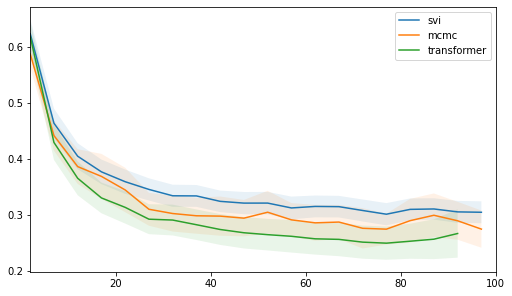

In [74]:
y_min = min([global_results[k][2].min() for k in global_results])
y_max = max([global_results[k][2].max() for k in global_results])

fig2 = plt.figure(constrained_layout=True, figsize=(7, 4))
axes = plt.axes()
axes.set_xlim(2, 100)
#axes.set_ylim(y_min, y_max)
for k in global_results:
    plot_with_confidence_intervals(plt, global_results[k][1], global_results[k][2], global_results[k][3], label=k)
    #plt.plot(global_results_train_steps[k][1], global_results_train_steps[k][0], label=k)
plt.legend(loc="upper right")